# Predict Real vs. Fake Images
#### The following notebook will try to predict whether an image is real or has been synthetically generated. Subseqeuntly, the robustness of the model will be tested and then transfer learning is utilized in order to further improve on the model. The dataset used for this exploration can be found here: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images

In [2]:
# Import necessary Libraries
import numpy as np 
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy
import cv2

import warnings
warnings.filterwarnings("ignore")

### Data Preparation: Load Image Dataset
The dataset has been split into training, test, and validation sets. 
The ImageDataGenerator enables us to "generate" batches of image data that can simultaneously be augmented according to specified inputs. 

It's important to note that that augmentation should only be applied to training data, not test or validation data in order to prevent data leakage. Augmentation artificially increases the diversity of the dataset in order to expose the model to a greater range of variation. It is important to refrain from introduced additional artificial variations in the test and validation data in order to not obtain overly optimistic results

In [3]:
batchNum = 128 # 128 images will be processed at a time
train_augmentor = ImageDataGenerator(
    rescale = 1./255, # pixel values are rescaled to lie between 0,1
    rotation_range = 10., # specifies that 10 degrees random rotation can be applied to the images during training
    width_shift_range = 0.1, # images can be shifted horizontally be 10% during training
    height_shift_range = 0.1, # images can be shifted vertically by 10% during training 
    zoom_range = 0.2, # images can be zoomed in or out by a maximum of 20%
    horizontal_flip = True) # images can be flipped horizontally during training

test_generator = ImageDataGenerator(rescale = 1./255) # test and valid data shall only be rescaled to match training data

training_data = train_augmentor.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Train', 
    target_size = (128,128), batch_size = batchNum, class_mode = 'binary')
test_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size = (128,128), batch_size = batchNum, class_mode = 'binary')
valid_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation',
    target_size = (128,128), batch_size = batchNum, class_mode='binary')

print(training_data.class_indices)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
{'Fake': 0, 'Real': 1}


### Data Visualization: Show various instances of real and fake images
The previous line of code highlights that class 0 corresponds to fake images, whereas class 1 corresponds to real images. To the naked eye it is quite difficult to distinguish between both classes, hence the use of a CNN in the following section. They are particularly good at finding patterns in image data. 

Fake images correspond to class: 0. Real images correspond to class: 1


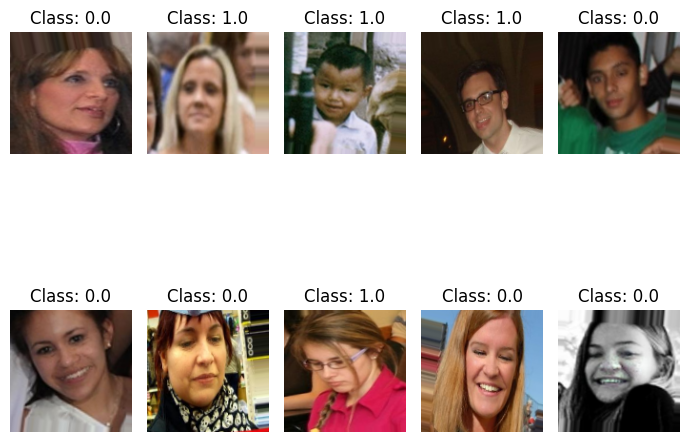

In [4]:
print("Fake images correspond to class: " + str(training_data.class_indices['Fake']) + ". Real images correspond to class: " + str(training_data.class_indices['Real']))

plt.figure(figsize=(7, 7))
for images, labels in training_data:
    for i in range(10):  # Displaying 10 images
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break  # Stop after the first batch
plt.tight_layout()
plt.show()



### Modeling: Define Convolutional Neural Network
CNNs are particularly well suited for image classification because: 
1. CNNs are good at learning hierarchical representations of features from pixels. Lower layers capture more simple features, whereas higher layers can capture more complex ones such as shapes or objects.
2. CNNs use filters (kernels) that slide across the image, hence can detect patterns no matter their location on the image
3. It is possible to include pooling layers when defining a CNN model, which reduce the spatial dimensions of the imagers while retaining their important information

In [5]:
model = Sequential()

# 2D Convolutional layer with 2 filters, each of kernel size 3x3. A ReLU activation function is used and the image shape corresponds to a height of 128 pixels, width of 128 and 3 input channels, hence RGB.
model.add(Conv2D(2, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
# Reduces the spatial dimensions by a factor of 2 along both dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(4, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Each convolutional layer extracts higher-level features. Moreover, each max pooling layer reduces the spatial dimensions. IN turn this reduces the computational complexity and hence time to completion as well as reduces the risk of overfitting.

# Output from the above layers is "flattened" into a 1D array, in order to pass it into the fully connected layers
model.add(Flatten())

model.add(Dense(64, activation="relu")) # 64 neurons
model.add(Dense(32, activation="relu")) # 32 Neurons
# Output layer has 1 neuron and uses Sigmoid which is suitable for binary classification tasks
model.add(Dense(1, activation="sigmoid")) 

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,637 (158.74 KB)

 Trainable params: 40,637 (158.74 KB)

 Non-trainable params: 0 (0.00 B)

### Modeling: Compile and Fit the Model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training set
history = model.fit(training_data, epochs=10, validation_data=valid_data)

# Evaluate the model on the Valid set
valid_loss, valid_acc = model.evaluate(valid_data)
print('Test accuracy:', valid_acc)

In [16]:
# Save the model
model.save("CNNPicture2Dataset.h5")

### Modeling: Plot Losses and Accuracies vs Epochs 
The ideal scenario for both plots is as follows: 
1. Training Loss Decreasing, Validation Loss Decreasing -> Both losses decrease over epochs, which indicates that the model is able to learn from the training data whilst continuing to generalize well to unseen data. Hence this would indicate that neither over- or underfitting is taking place
2. Training Accuracy Increasing, Validation Accuracy Increasing -> this suggests the same as above

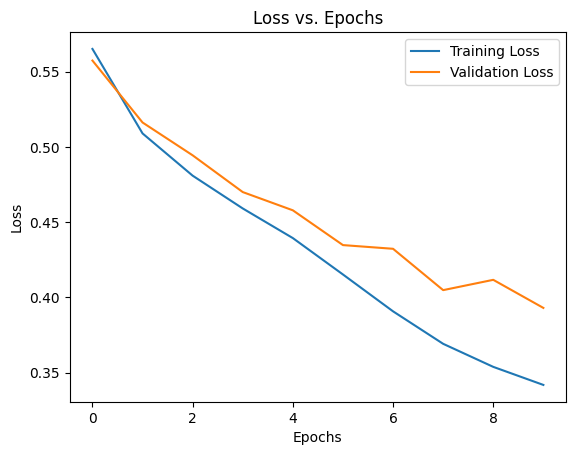

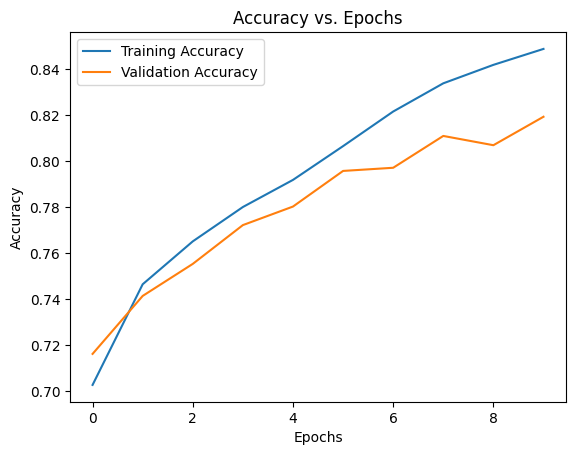

In [9]:
# Plot losses vs epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracies vs epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Modeling: Evaluating the Model
For the purpose of this proof of concept, we shall evaluate the model on 6 randomly chosen images: 3 real and 3 fake. The first 3 are fake images and the latter 3 are real images. 

Enter the path to the image:  /Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation/Fake/fake_892.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: Fake


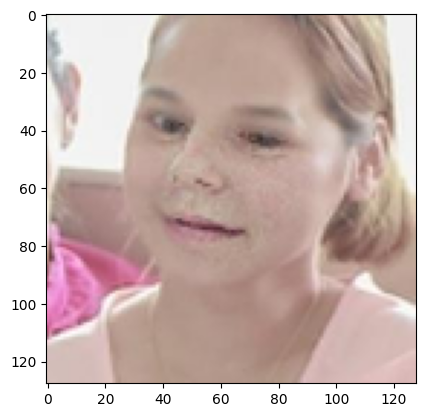

In [15]:
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model("CNNPicture2Dataset.h5")

# Function to preprocess the user-provided image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    plt.imshow(img)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict whether the image is real or fake
def predict_real_or_fake(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    # The prediction needs to be > 0.5 for the image to be classified as real because real images belong to the class 1
    if prediction[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"

# User provides the image path
image_path = input("Enter the path to the image: ")

# Predict whether the image is real or fake
prediction = predict_real_or_fake(image_path)
print("Prediction:", prediction)

Enter the path to the image:  /Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation/Fake/fake_930.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: Fake


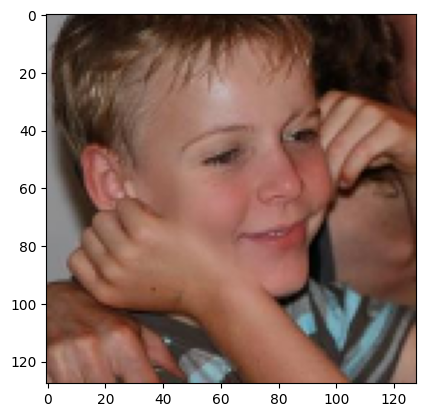

In [20]:
# User provides the image path
image_path = input("Enter the path to the image: ")

# Predict whether the image is real or fake
prediction = predict_real_or_fake(image_path)
print("Prediction:", prediction)

Enter the path to the image:  /Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation/Fake/fake_946.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction: Fake


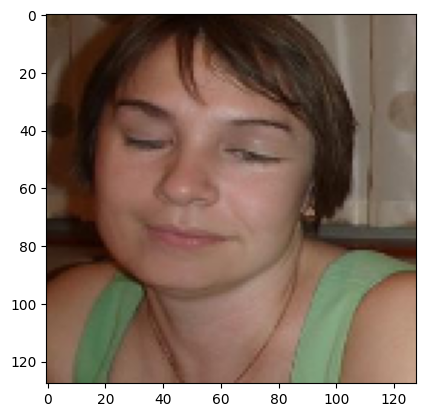

In [21]:
# User provides the image path
image_path = input("Enter the path to the image: ")

# Predict whether the image is real or fake
prediction = predict_real_or_fake(image_path)
print("Prediction:", prediction)

Enter the path to the image:  /Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation/Real/real_9796.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction: Real


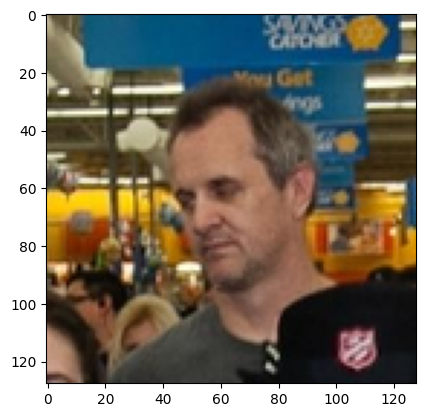

In [22]:
# User provides the image path
image_path = input("Enter the path to the image: ")

# Predict whether the image is real or fake
prediction = predict_real_or_fake(image_path)
print("Prediction:", prediction)

Enter the path to the image:  /Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation/Real/real_9739.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prediction: Real


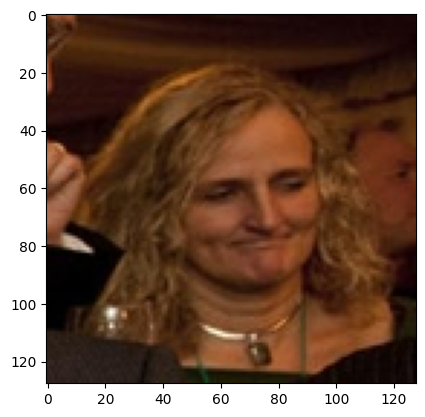

In [23]:
# User provides the image path
image_path = input("Enter the path to the image: ")

# Predict whether the image is real or fake
prediction = predict_real_or_fake(image_path)
print("Prediction:", prediction)

Enter the path to the image:  /Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation/Real/real_9799.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction: Real


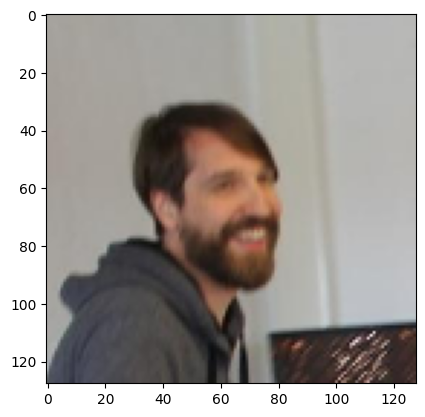

In [24]:
# User provides the image path
image_path = input("Enter the path to the image: ")

# Predict whether the image is real or fake
prediction = predict_real_or_fake(image_path)
print("Prediction:", prediction)

### Modeling: Evaluate the Model on all images held in the test set

In [18]:
model = tf.keras.models.load_model("CNNPicture2Dataset.h5")
evaluation_result = model.evaluate(test_data)
print("The accuracy, hence the percentage of accurately classified images within test_data is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.8564 - loss: 0.3341
The accuracy, hence the percentage of accurately classified images within test_data is: 0.8543787002563477%
The loss is:  0.33881592750549316


## Evaluation: 
### Convert Validation Images to Greyscale and Check Classification Accuracy
We identified several potential benefits in checking whether our model can accurately distinguish between real and fake greyscale images including: 
1. Testing Model Robustness: this exploration can help to evaluate the robustness of our model against image transformations. This is crucial for practical applications
2. Understanding Important Image Features: analyzing how the model performs in the presence of changes in color can provide insights into which features it relies on for decision-making

In [4]:
from PIL import Image

# Define a function to convert images to grayscale
def rgb_to_gray(rgb_image):
    # Convert RGB to grayscale using numpy array operations
    gray_image = np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.11409])
    # Expand dimensions to match the expected shape by Keras
    gray_image = np.expand_dims(gray_image, axis=-1)
    return gray_image

batchNum = 128  # 128 images will be processed at a time

test_generator_greyscale = ImageDataGenerator(rescale=1./255, preprocessing_function=rgb_to_gray)  # Test and valid data shall only be rescaled to match training data

test_data_greyscale = test_generator_greyscale.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size=(128, 128), batch_size=batchNum, class_mode='binary'
)

print(test_data_greyscale.class_indices)

Found 39428 images belonging to 2 classes.
{'Fake': 0, 'Real': 1}


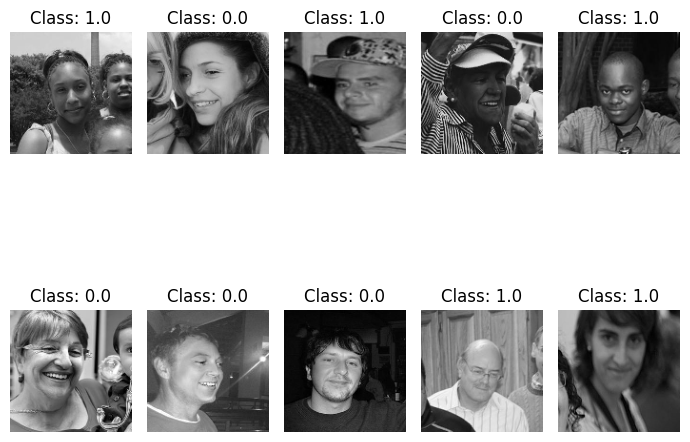

In [5]:
plt.figure(figsize=(7, 7))
for images, labels in test_data_greyscale:
    for i in range(10):  # Displaying 10 images
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension and display in grayscale
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break  # Stop after the first batch
plt.tight_layout()
plt.show()

In [6]:
model = tf.keras.models.load_model("CNNPicture2Dataset.h5")
evaluation_result = model.evaluate(test_data_greyscale)
print("The accuracy, hence the percentage of accurately classified images within test_data_greyscale is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

309/309 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.8253 - loss: 0.3834
The accuracy, hence the percentage of accurately classified images within valid_data is: 0.8242619633674622%
The loss is:  0.3841841220855713


## Evaluation: 
### Reduce brightness level of images and Check Classification Accuracy
We identified several potential benefits in checking whether our model can accurately distinguish between real and fake greyscale images including: 
1. Testing Model Robustness: this exploration can help to evaluate the robustness of our model against image transformations. This is crucial for practical applications
2. Understanding Important Image Features: nalyzing how the model performs in the presence of changes in color can provide insights into which features it relies on for decision-making

In [9]:
batchNum = 128
test_generator_dark = ImageDataGenerator(rescale=1./255, brightness_range=(0.3, 0.3)) # test and valid data shall only be rescaled to match training data

test_data_dark = test_generator_dark.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size = (128,128), batch_size = batchNum, class_mode='binary')


Found 39428 images belonging to 2 classes.


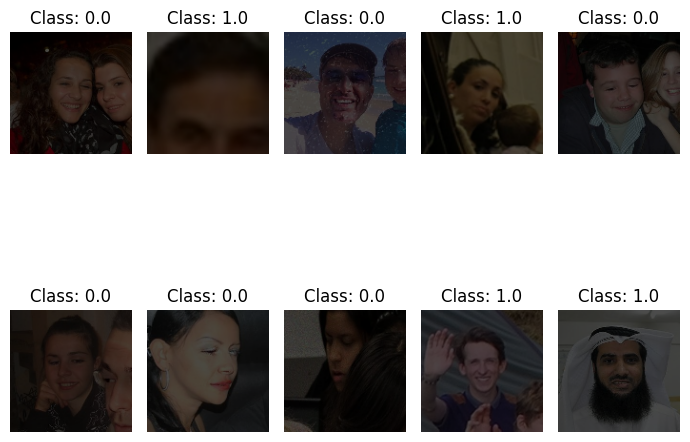

In [10]:
plt.figure(figsize=(7, 7))
for images, labels in test_data_dark:
    for i in range(10):  # Displaying 10 images
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break  # Stop after the first batch
plt.tight_layout()
plt.show()

In [11]:
model = tf.keras.models.load_model("CNNPicture2Dataset.h5")
evaluation_result = model.evaluate(test_data_dark)
print("The accuracy, hence the percentage of accurately classified images within test_data_dark is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

309/309 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.7549 - loss: 0.5042
The accuracy, hence the percentage of accurately classified images within valid_data is: 0.753398597240448%
The loss is:  0.5046948194503784


## Evaluation: 
### Blur the Images and check Classification Accuracy

In [15]:
batchNum = 128
import cv2

def apply_blur(image):
    blurred_image = cv2.GaussianBlur(image, (9, 9), 2)  # You can adjust the kernel size as needed
    return blurred_image

test_generator_blur = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_blur) # test and valid data shall only be rescaled to match training data

test_data_blurred = test_generator_blur.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size = (128,128), batch_size = batchNum, class_mode='binary')

Found 39428 images belonging to 2 classes.


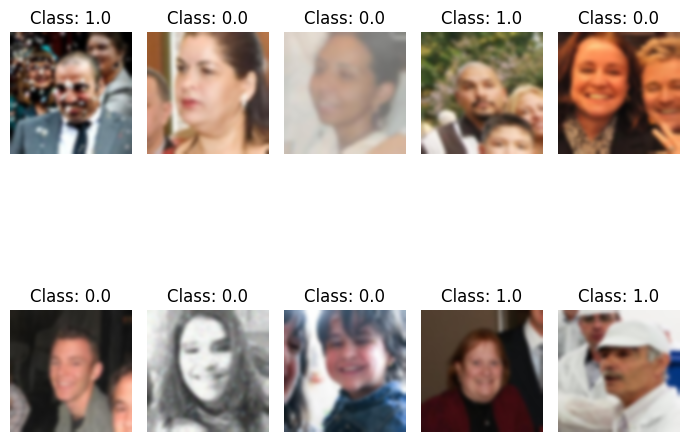

In [16]:
plt.figure(figsize=(7, 7))
for images, labels in test_data_blurred:
    for i in range(10):  # Displaying 10 images
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break  # Stop after the first batch
plt.tight_layout()
plt.show()

In [17]:
model = tf.keras.models.load_model("CNNPicture2Dataset.h5")
evaluation_result = model.evaluate(test_data_blurred)
print("The accuracy, hence the percentage of accurately classified images within test_data_blurred is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

309/309 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.7008 - loss: 0.5838
The accuracy, hence the percentage of accurately classified images within valid_data_blurred is: 0.7001369595527649%
The loss is:  0.5829943418502808


## Transfer Learning:
### Retrain Model with Blurred Images

In [19]:
batchNum = 128 # 128 images will be processed at a time

def apply_blur(image):
    blurred_image = cv2.GaussianBlur(image, (9, 9), 2)  # You can adjust the kernel size as needed
    return blurred_image

train_augmentor = ImageDataGenerator(
    rescale = 1./255, # pixel values are rescaled to lie between 0,1
    rotation_range = 10., # specifies that 10 degrees random rotation can be applied to the images during training
    width_shift_range = 0.1, # images can be shifted horizontally be 10% during training
    height_shift_range = 0.1, # images can be shifted vertically by 10% during training 
    zoom_range = 0.2, # images can be zoomed in or out by a maximum of 20%
    horizontal_flip = True, # images can be flipped horizontally during training
    preprocessing_function=apply_blur) # apply blur to the training data

test_generator = ImageDataGenerator(rescale = 1./255, preprocessing_function=apply_blur) # test and valid data shall only be rescaled to match training data

training_data = train_augmentor.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Train', 
    target_size = (128,128), batch_size = batchNum, class_mode = 'binary')
test_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size = (128,128), batch_size = batchNum, class_mode = 'binary')
valid_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation',
    target_size = (128,128), batch_size = batchNum, class_mode='binary')

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


Fake images correspond to class: 0. Real images correspond to class: 1


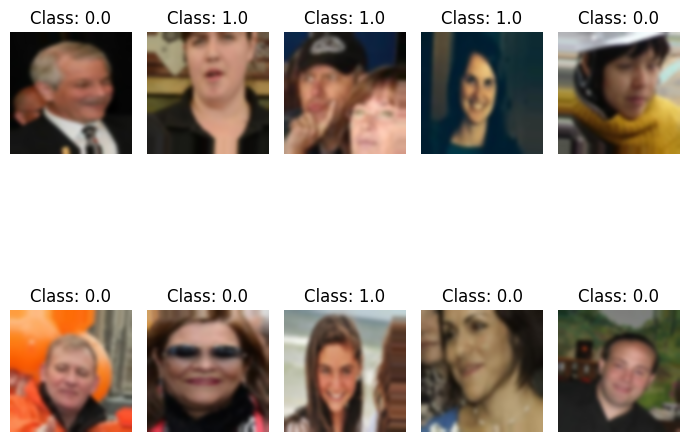

In [13]:
print("Fake images correspond to class: " + str(training_data.class_indices['Fake']) + ". Real images correspond to class: " + str(training_data.class_indices['Real']))

plt.figure(figsize=(7, 7))
for images, labels in training_data:
    for i in range(10):  # Displaying 10 images
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break  # Stop after the first batch
plt.tight_layout()
plt.show()

In [14]:
model = tf.keras.models.load_model("CNNPicture2Dataset.h5")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model on the training set
history = model.fit(training_data, epochs=10, validation_data=valid_data)

# Evaluate the model on the valid set
valid_loss, valid_acc = model.evaluate(valid_data)
print('Test accuracy:', valid_acc)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 345s 313ms/step - accuracy: 0.7956 - loss: 0.4324 - val_accuracy: 0.8132 - val_loss: 0.4056
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 330s 300ms/step - accuracy: 0.8165 - loss: 0.3971 - val_accuracy: 0.7919 - val_loss: 0.4281
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 315s 286ms/step - accuracy: 0.8208 - loss: 0.3890 - val_accuracy: 0.8187 - val_loss: 0.3961
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 314s 286ms/step - accuracy: 0.8253 - loss: 0.3822 - val_accuracy: 0.8221 - val_loss: 0.3905
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 315s 286ms/step - accuracy: 0.8288 - loss: 0.3763 - val_accuracy: 0.8255 - val_loss: 0.3804
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 329s 299ms/step - accuracy: 0.8322 - loss: 0.3688 - val_accuracy: 0.8266 - val_loss: 0.3787
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 322s 292ms/step - accuracy: 0.8357 - loss: 0.3667 - val_accuracy: 0.8243 - val_loss: 0.3831
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 320s 291ms/step - ac

In [15]:
evaluation_result = model.evaluate(test_data)
print("The accuracy, hence the percentage of accurately classified images within the blurred test data is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

309/309 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8383 - loss: 0.3621
The accuracy, hence the percentage of accurately classified images within the blurred validation data is: 0.8391752243041992%
The loss is:  0.3620992600917816


In [7]:
model.save("CNN_with_Blur.h5")
model = tf.keras.models.load_model("CNN_with_Blur.h5")

## Transfer Learning:
### Retrain Model with darker images

In [10]:
batchNum = 128 # 128 images will be processed at a time

train_augmentor = ImageDataGenerator(
    rescale = 1./255, # pixel values are rescaled to lie between 0,1
    rotation_range = 10., # specifies that 10 degrees random rotation can be applied to the images during training
    width_shift_range = 0.1, # images can be shifted horizontally be 10% during training
    height_shift_range = 0.1, # images can be shifted vertically by 10% during training 
    zoom_range = 0.2, # images can be zoomed in or out by a maximum of 20%
    horizontal_flip = True, # images can be flipped horizontally during training
    brightness_range=(0.3, 0.3)) # reduce the brightness of the training images by a factor of 0.3

test_generator = ImageDataGenerator(rescale = 1./255, brightness_range=(0.3, 0.3)) # test and valid data shall only be rescaled to match training data

training_data = train_augmentor.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Train', 
    target_size = (128,128), batch_size = batchNum, class_mode = 'binary')
test_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size = (128,128), batch_size = batchNum, class_mode = 'binary')
valid_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Validation',
    target_size = (128,128), batch_size = batchNum, class_mode='binary')

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


Fake images correspond to class: 0. Real images correspond to class: 1


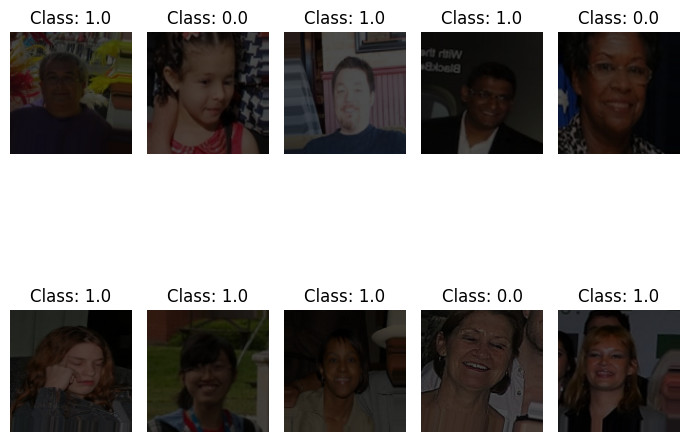

In [19]:
print("Fake images correspond to class: " + str(training_data.class_indices['Fake']) + ". Real images correspond to class: " + str(training_data.class_indices['Real']))

plt.figure(figsize=(7, 7))
for images, labels in training_data:
    for i in range(10):  # Displaying 10 images
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break  # Stop after the first batch
plt.tight_layout()
plt.show()

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model on the training set
history = model.fit(training_data, epochs=10, validation_data=valid_data)

# Evaluate the model on the valid set
valid_loss, valid_acc = model.evaluate(valid_data)
print('Test accuracy:', valid_acc)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 359s 326ms/step - accuracy: 0.8469 - loss: 0.3463 - val_accuracy: 0.8301 - val_loss: 0.3823
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 372s 338ms/step - accuracy: 0.8638 - loss: 0.3133 - val_accuracy: 0.8456 - val_loss: 0.3548
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 368s 334ms/step - accuracy: 0.8657 - loss: 0.3077 - val_accuracy: 0.8463 - val_loss: 0.3513
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 383s 348ms/step - accuracy: 0.8709 - loss: 0.3009 - val_accuracy: 0.8492 - val_loss: 0.3509
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 380s 346ms/step - accuracy: 0.8717 - loss: 0.2951 - val_accuracy: 0.8511 - val_loss: 0.3441
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 380s 346ms/step - accuracy: 0.8742 - loss: 0.2913 - val_accuracy: 0.8438 - val_loss: 0.3516
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 377s 342ms/step - accuracy: 0.8744 - loss: 0.2917 - val_accuracy: 0.8436 - val_loss: 0.3537
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 375s 341ms/step - ac

In [13]:
evaluation_result = model.evaluate(test_data)
print("The accuracy, hence the percentage of accurately classified images within the blurred test data is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

309/309 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.8654 - loss: 0.3163
The accuracy, hence the percentage of accurately classified images within the blurred test data is: 0.8625596165657043%
The loss is:  0.31735020875930786


In [14]:
model.save("CNN_with_BlurAndDark.h5")
model = tf.keras.models.load_model("CNN_with_BlurAndDark.h5")

## Evaluation of Transfer Learning
#### In the following code the model which has now been trained on the initial normal images, blurred, and darker images is evaluated on the initial test set

In [15]:
test_generator = ImageDataGenerator(rescale = 1./255) # test and valid data shall only be rescaled to match training data

test_data = test_generator.flow_from_directory(
    '/Users/timseidel/Documents/DHBW_Studium/Machine_Learning_Project/Dataset/Test',
    target_size = (128,128), batch_size = batchNum, class_mode='binary')

evaluation_result = model.evaluate(test_data)
print("The accuracy, hence the percentage of accurately classified images within the initial test data is: " + str(evaluation_result[1]) + "%")
print("The loss is: ", evaluation_result[0])

Found 39428 images belonging to 2 classes.
309/309 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8289 - loss: 0.5071
The accuracy, hence the percentage of accurately classified images within the initial test data is: 0.8265445828437805%
The loss is:  0.5144679546356201


### Special thanks to my peers Jack Gilbert, Sven Heidschmidt and Max Symelka